# World Cup prediction example

## Notebook and code from https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner

# Data 
- FIFA rankings from 1993 to 2018 (courtesy of [Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald) 
- International Soccer matches from 1872 to 2018 (courtesy of [Mart Jürisoo](https://www.kaggle.com/martj42))
- FIFA World Cup 2018 data set (courtesy of [Nuggs](https://www.kaggle.com/ahmedelnaggar))

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

In [4]:
matches = pd.read_csv('international-football-results-from-1872-to-2017/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

In [5]:
world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

In [6]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [8]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

In [12]:
# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


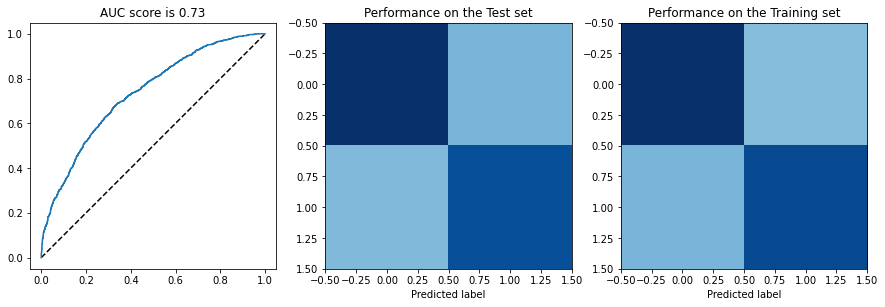

In [13]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

In [14]:
# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [19]:
import progressbar

simulation_results = list()
n_simulations = 10000
#bar = progressbar.ProgressBar(max_value=n_simulations)

for i in range(n_simulations):
    #bar.update(i)
    candidates = ['France', 'Argentina', 'Uruguay', 'Portugal', 
                  'Spain', 'Russia','Croatia', 'Denmark', 
                  'Brazil', 'Mexico', 'Belgium', 'Japan', 
                  'Sweden', 'Switzerland', 'Colombia', 'England']
    finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

    for f in finals:
        iterations = int(len(candidates) / 2)
        winners = []

        for i in range(iterations):
            home = candidates[i*2]
            away = candidates[i*2+1]
            
            row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
            home_rank = world_cup_rankings.loc[home, 'rank']
            home_points = world_cup_rankings.loc[home, 'weighted_points']
            opp_rank = world_cup_rankings.loc[away, 'rank']
            opp_points = world_cup_rankings.loc[away, 'weighted_points']
            row['average_rank'] = (home_rank + opp_rank) / 2
            row['rank_difference'] = home_rank - opp_rank
            row['point_difference'] = home_points - opp_points

            home_win_prob = model.predict_proba(row)[:,1][0]
            
            # simulation step based on the probability
            simulated_outcome = np.random.binomial(1, home_win_prob)
            winners.append(away) if simulated_outcome <= 0.5 else winners.append(home)
        candidates = winners
    simulations_results = simulation_results.append(candidates)

simulation_results = sum(simulation_results, [])

Text(0, 0.5, 'Winning probability')

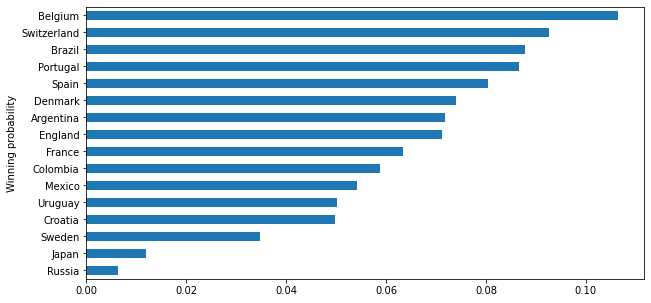

In [20]:
pd.Series(simulation_results).value_counts().sort_values().divide(n_simulations).plot.barh(figsize=(10,5))
plt.ylabel('Winning probability')